In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd, Day
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import datetime as datetime
import time

In [2]:
#read data
FileSource = '/Users/scarlett/Desktop/Uchi_Application_Material/code_Uchi/'
rawdata = pd.read_excel(FileSource + 'stock_data.xlsx')
#read Fama French 5 Factoe data
FF5 = pd.read_csv(FileSource + "FF5_monthly.csv")

In [3]:
#data formatting

ff5 = FF5.copy()
ff5['trdmn'] = ff5['trdmn'].astype('str').apply(lambda x:datetime.datetime.strptime(x,'%Y%m'))

df_stock = rawdata.copy()

df_stock['security_code'] = df_stock['security_code'].apply(lambda x:str(x).zfill(6))

df_stock['trans_month']  = df_stock['trans_month'].astype('str')
df_stock['trans_month'] = df_stock['trans_month'].apply(lambda x:datetime.datetime.strptime(x,'%Y%m'))

df_stock['mkt_cap_ttl'] = df_stock['mkt_cap_ttl'].astype('str').apply(lambda x:np.nan if x=='$' or x == '&' else x)
df_stock['mkt_cap_cir'] = df_stock['mkt_cap_cir'].astype('str').apply(lambda x:np.nan if x=='&' else x)
df_stock['return_rate'] = df_stock['return_rate'].apply(lambda x:np.nan if x=='#' else x)

df_stock['mkt_cap_cir'] = pd.to_numeric(df_stock['mkt_cap_cir'])
df_stock['mkt_cap_ttl'] = pd.to_numeric(df_stock['mkt_cap_ttl'])
df_stock['return_rate'] = pd.to_numeric(df_stock['return_rate'])

In [4]:
#Determine whether the observations for each individual stock are continuous
df_stock_gb_code = df_stock.groupby('security_code')
Monthdiff = df_stock_gb_code.apply(lambda x:x['trans_month'].dt.month.diff())
print(Monthdiff[Monthdiff>1])

#Handling of discontinuous data
CodeSet = df_stock_gb_code['security_code'].count().index.tolist()
CodeSet.sort()

Start = df_stock_gb_code['trans_month'].min()
End = df_stock_gb_code['trans_month'].max()

b = pd.DataFrame()

for i in range(len(CodeSet)):
    code = CodeSet[i]
    start = Start[i]
    end = End[i]
    a = df_stock[df_stock['security_code'] == code]
    con = pd.MultiIndex.from_product([a['security_code'].unique(),pd.date_range(start,end,freq = 'MS')],
                                 names = ['security_code','trans_month'])
    a = a.set_index(['security_code','trans_month']).reindex(con,fill_value = np.NaN).reset_index()
    
    b = pd.concat([a,b])

df_stock_fill = b.fillna(method = 'ffill',axis = 0)
df_stock_fill = df_stock_fill.sort_values(by=['security_code','trans_month'])


security_code        
000001         102       3.0
000007         784       4.0
               793       6.0
               802       6.0
000008         977       3.0
                        ... 
603960         425784    3.0
603977         426062    4.0
603997         426688    5.0
603998         426709    2.0
               426741    3.0
Name: trans_month, Length: 2859, dtype: float64


In [5]:
#Screen for stocks with 36+ months of return data
df_stock_gb_count = df_stock_fill.groupby('security_code',as_index=False).agg({'return_rate':'count'})
codeset1 = df_stock_gb_count[df_stock_gb_count['return_rate'] < 36]['security_code'].to_list()
df_stock_fill = df_stock_fill.loc[~df_stock_fill['security_code'].isin(codeset1)]

#Cumulative return rate per three months and per six months (cumulative return factor)
df_stock_fill['return_rate_1'] = df_stock_fill['return_rate']+1

df_stock_fill['cumret3'] = df_stock_fill['return_rate_1'].rolling(window=3).sum()
df_stock_fill['cumret6'] = df_stock_fill['return_rate_1'].rolling(window=6).sum()

Text(0.5, 1.0, 'cumret6_H-L_CumRet')

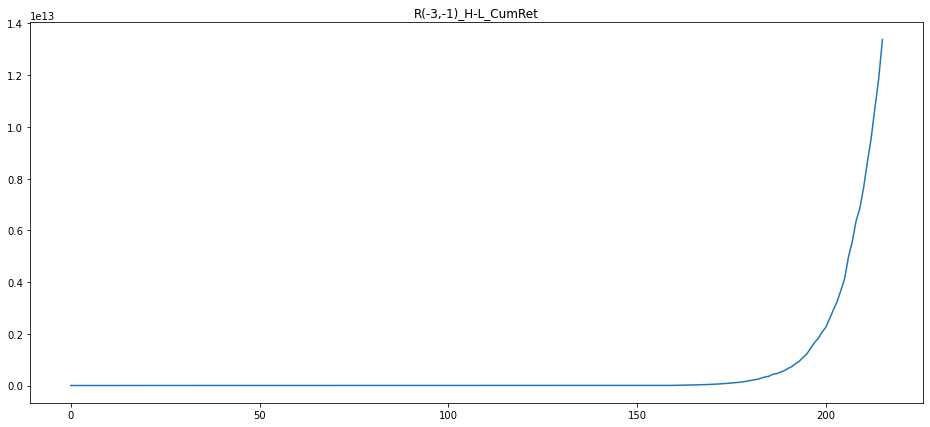

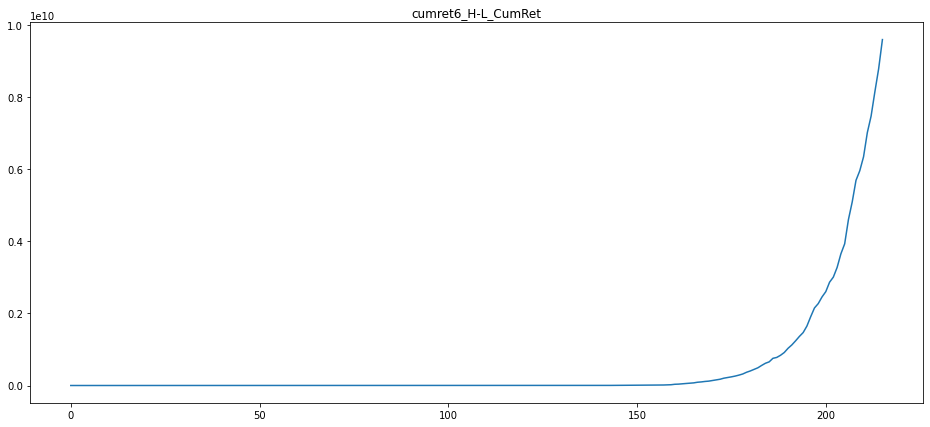

In [6]:
#Grouping of stocks based on cumulative returns
df_cumret3 = df_stock_fill[['security_code','trans_month','return_rate','cumret3']].dropna(subset = [
    'cumret3','trans_month','security_code','return_rate'])
df_cumret6 = df_stock_fill[['security_code','trans_month','return_rate','cumret6']].dropna(subset = [
    'cumret6','trans_month','security_code','return_rate'])

#Split the individual stocks in each month into three groups, H, M, and L, based on their cumulative returns 
df_HL = pd.DataFrame()
df_HL['Month'] =  df_stock_fill.groupby('trans_month')['trans_month'].first()

Month1 = df_cumret3.groupby('trans_month')['trans_month'].first()
df_cumret3['cumret3_gp'] = pd.Series()
for i in Month1:
    df_cumret3.loc[df_cumret3['trans_month'] == i,'cumret3_gp'] = pd.qcut(df_cumret3.loc[df_cumret3['trans_month'] == i]['cumret3'],q=[0,0.25,0.75,1],labels = ['L','M','H'])
Port1 = df_cumret3.groupby(['trans_month','cumret3_gp'])['return_rate'].mean().unstack()
df_HL['return_rate3_HL'] = Port1['H']-Port1['L']

Month2 = df_cumret6.groupby('trans_month')['trans_month'].first()
df_cumret6['cumret6_gp'] = pd.Series()
for i in Month2:
    df_cumret6.loc[df_cumret6['trans_month'] == i,'cumret6_gp'] = pd.qcut(df_cumret6.loc[df_cumret6['trans_month'] == i]['cumret6'],q=[0,0.25,0.75,1],labels = ['L','M','H'])
Port2 = df_cumret6.groupby(['trans_month','cumret6_gp'])['return_rate'].mean().unstack()
df_HL['return_rate6_HL'] = Port2['H']-Port2['L']

df_HL = df_HL.drop(columns=['Month']).reset_index()

#Compute the cumulative return on the H-L asset portfolio
df_HL['cumret3_HL'] = df_HL['return_rate3_HL'] + 1
df_HL['cumret6_HL'] = df_HL['return_rate6_HL'] + 1

df_HL['cumret3_HL'] = df_HL['cumret3_HL'].cumprod(axis = 0)
df_HL['cumret6_HL'] = df_HL['cumret6_HL'].cumprod(axis = 0)

df_HL['cumret3_HL'] = df_HL['cumret3_HL'] - 1
df_HL['cumret6_HL'] = df_HL['cumret6_HL'] - 1

#Plot the time trajectory of cumulative returns
plt.figure(figsize = (16,7))
df_HL['cumret3_HL'].plot(kind = 'line')
plt.title('R(-3,-1)_H-L_CumRet')

plt.figure(figsize = (16,7))
df_HL['cumret6_HL'].plot(kind = 'line')
plt.title('cumret6_H-L_CumRet')

In [7]:
df_HL

,trans_month,return_rate3_HL,return_rate6_HL,cumret3_HL,cumret6_HL
0,2002-01-01,0.149885,0.100841,1.498845e-01,1.008406e-01
1,2002-02-01,0.006685,0.018716,1.575719e-01,1.214439e-01
2,2002-03-01,0.081917,0.056066,2.523962e-01,1.843183e-01
3,2002-04-01,0.106249,0.070011,3.854618e-01,2.672341e-01
4,2002-05-01,0.087291,0.061454,5.063999e-01,3.451106e-01
...,...,...,...,...,...
211,2019-08-01,0.130050,0.105651,8.620524e+12,7.022783e+09
212,2019-09-01,0.106200,0.065359,9.536024e+12,7.481784e+09
213,2019-10-01,0.124288,0.090217,1.072124e+13,8.156768e+09
214,2019-11-01,0.104061,0.078496,1.183690e+13,8.797041e+09


In [8]:
#The cumulative return factor was regressed against FF5 to determine if there was a significant alpha
factor_ttl = pd.merge(df_HL,ff5,how = 'inner',left_on='trans_month',right_on = 'trdmn')

factor_ttl3 = factor_ttl.copy().dropna(subset = ['cumret3_HL','mkt_rf','smb','hml','rmw','cma'])
factor_ttl6 = factor_ttl.copy().dropna(subset = ['cumret6_HL','mkt_rf','smb','hml','rmw','cma'])

alpha = []
tvalue = []
pvalue = []

y1 = factor_ttl3['cumret3_HL']
x1 = factor_ttl3[['mkt_rf','smb','hml','rmw','cma']]
x1 = sm.add_constant(x1)
reg1 = sm.OLS(y1,x1,cov_kwds={'maxlags':6})
result1 = reg1.fit()
alpha.append(result1.params[0])
tvalue.append(result1.tvalues[0])
pvalue.append(result1.pvalues[0])

y2 = factor_ttl6['cumret6_HL']
x2 = factor_ttl6[['mkt_rf','smb','hml','rmw','cma']]
x2 = sm.add_constant(x2)
reg2 = sm.OLS(y2,x2,cov_kwds={'maxlags':6})
result2 = reg2.fit()
alpha.append(result2.params[0])
tvalue.append(result2.tvalues[0])
pvalue.append(result2.pvalues[0])

reg_rlt = pd.DataFrame()
reg_rlt['alpha'] = alpha
reg_rlt['t'] = tvalue
reg_rlt['p'] = pvalue
reg_rlt['factor'] = ['cumret3','cumret6']
reg_rlt.set_index('factor')
#the result means that all alpha significant, the factor cannot be explained by the FF5 factor

,alpha,t,p
factor,,,
cumret3,6.225144e+11,4.287258,0.000028
cumret6,5.926089e+08,5.034243,0.000001


In [9]:
#Perform a contemporaneous regression of the factors on individual stock returns
#Determine the explanatory power of the factors on individual stock returns
CodeSet_3 = df_cumret3.groupby('security_code').count().index.tolist()
CodeSet_6 = df_cumret6.groupby('security_code').count().index.tolist()

In [10]:
#regression for 3 months Cumulative return
tvalues_3 = []
params_3 = []
rsquared_3 = []

for i in CodeSet_3:
    y = df_cumret3.loc[df_cumret3['security_code'] == i,'return_rate']
    x = df_cumret3.loc[df_cumret3['security_code'] == i,'cumret3']
    x = sm.add_constant(x)
    Reg = sm.OLS(y,x,cov_type='HAC', cov_kwds={'maxlags': 6})
    Result = Reg.fit()
    tvalues_3.append(Result.tvalues[-1])
    params_3.append(Result.params[-1])
    rsquared_3.append(Result.rsquared)

#Storing regression results into a dataframe
reg2_rlt = pd.DataFrame()
reg2_rlt['security_code'] = CodeSet_3
reg2_rlt['b'] = params_3
reg2_rlt['t'] = tvalues_3
reg2_rlt['R^2'] = rsquared_3
reg2_rlt = reg2_rlt.sort_values(by="security_code")
reg2_rlt

,security_code,b,t,R^2
0,000001,0.322835,11.553969,0.386386
1,000002,0.337323,17.693665,0.593979
2,000006,0.317603,10.595586,0.344094
3,000007,0.329691,10.059552,0.321054
4,000008,0.323457,11.311849,0.374192
...,...,...,...,...
2986,603993,0.315355,5.761909,0.280877
2987,603996,0.342880,4.519353,0.302925
2988,603997,0.332215,4.598686,0.274122
2989,603998,0.299677,5.247797,0.318229


In [11]:
#regression for 6 months Cumulative return
tvalues_6 = []
params_6 = []
rsquared_6 = []

for i in CodeSet_6:
    y = df_cumret6.loc[df_cumret6['security_code'] == i,'return_rate']
    x = df_cumret6.loc[df_cumret6['security_code'] == i,'cumret6']
    x = sm.add_constant(x)
    Reg = sm.OLS(y,x,cov_type='HAC', cov_kwds={'maxlags': 6})
    Result = Reg.fit()
    tvalues_6.append(Result.tvalues[-1])
    params_6.append(Result.params[-1])
    rsquared_6.append(Result.rsquared)

#Storing regression results into a dataframe
reg3_rlt = pd.DataFrame()
reg3_rlt['security_code'] = CodeSet_6
reg3_rlt['b'] = params_6
reg3_rlt['t'] = tvalues_6
reg3_rlt['R^2'] = rsquared_6
reg3_rlt = reg3_rlt.sort_values(by="security_code")
reg3_rlt

,security_code,b,t,R^2
0,000001,0.154467,7.342997,0.205080
1,000002,0.154483,11.352409,0.375870
2,000006,0.160301,6.926314,0.183124
3,000007,0.155965,6.231208,0.153575
4,000008,0.170683,8.207117,0.239400
...,...,...,...,...
2986,603993,0.166094,3.868705,0.149718
2987,603996,0.187806,2.751725,0.138752
2988,603997,0.204724,2.799376,0.122759
2989,603998,0.179058,4.021348,0.215125


### 4. 因子载荷动态变化下的动态资产组合分析

运用整理好的数据，继续做以下操作：


- 取累计收益最高的策略的H-L收益序列，标记为$\tilde{r}_{H-L,t}^{*}$.

- 保证每只股票的"return_rate"和累计收益最高的策略观测值不少了36个月

- 以24个月为窗口，在第t期对每个股票$i$进行以下线性回归，这里考虑'HAC'稳健标准误差且滞后期设置为12个月，
$$r_{t-1}^{i}=\alpha_{i}+\beta_{it}\tilde{r}_{H-L,t-2}^{*}+\varepsilon_{t-1}^{i},$$
调用命令如下，
```python
from statsmodels.regression.rolling import RollingOLS
```
运用pickle保存每个股票每个月的回归拟合对象(.fit())

- 由上述算出来的$\beta_{it}$,可知它随时间变动而变动，计算每只股票$i$的$\beta_{it}$的均值和标准差，输出前10行（按照"security_code"排序），分别画出它们的箱状图。
- 按照上述步骤处理完后，每个月对$\beta_{it}$进行标准化，使其均值为0，方差为1.
- 按照标准化后的$\beta_{it}$对当月所有股票进行分成5组，算出各组的等权重资产组合收益率，结果放在一个新的DataFrame里,输出该DataFrame的前10行（按照"security_code"升序）。
- 按照上面5组计算H-L资产投资组合，按照第2小题计算该策略的累计收益率并画出轨迹图。

In [12]:
##Select the sequence with the highest cumulative return on the H-L portfolio
df_H_hest = df_HL[['trans_month','return_rate6_HL','cumret6_HL']].copy().dropna(subset = ['cumret6_HL'])

# CHECK The "return_rate" for each stock and the H-L cumret6 has been observed for not less than 36 months.
Count_month = df_cumret6.groupby('security_code')['return_rate'].count()
stock_less_36_rr = Count_month[Count_month < 36].index.tolist() 
print(stock_less_36_rr)#there is no security with observed return rate less than 36

Count_month = df_cumret6.groupby('security_code')['cumret6'].count()
stock_less_36_cumr = Count_month[Count_month < 36].index.tolist()
print(stock_less_36_cumr)#there is no security with month observed cumret for 6 months less than 36 

[]
[]


Implement the regression, $$r_{t-1}^{i}=\alpha_{i}+\beta_{it}\tilde{r}_{H-L,t-2}^{*}+\varepsilon_{t-1}^{i}$$

where $r_{t-1}^{i}$ is the return rate for individual stock i at time t-1, $\tilde{r}_{H-L,t-2}^{*}$ is the cumret for H-L strategy at time t-2


In [13]:
merge_all = pd.merge(df_cumret6,df_H_hest,on ='trans_month',how='outer')
merge_all = merge_all[['security_code','trans_month','return_rate','cumret6_HL']]

total = pd.DataFrame(columns = ['security_code','trans_month','return_rate','cumret6_HL'])
RolResult_stat = pd.DataFrame()

code_reg4 = df_cumret6.groupby('security_code').count().index.tolist()
RolResult_stat['security_code'] = code_reg4

from statsmodels.regression.rolling import RollingOLS
for i in code_reg4:
    y = merge_all.loc[merge_all['security_code'] == i,'return_rate']
    x = merge_all.loc[merge_all['security_code'] == i,'cumret6_HL']
    x = sm.add_constant(x)
    RolReg = RollingOLS(y, x, window=24)
    RolResult = RolReg.fit(cov_type='HAC', cov_kwds={'maxlags': 12})

    bt = RolResult.params.iloc[:,1]
    bt = bt.reset_index(drop = True)

    temp = merge_all.loc[merge_all['security_code'] == i]
    temp = temp.sort_values(by = ['security_code',"trans_month"]).reset_index(drop = True)

    temp['beta'] = bt
    total = pd.concat([total,temp])
    
total = total.sort_values(by = ['security_code',"trans_month"])

In [14]:
total[total['trans_month'] == pd.to_datetime('2002-01-01')]

,security_code,trans_month,return_rate,cumret6_HL,beta
0,000002,2002-01-01 00:00:00,-0.072659,0.100841,NaN
0,000006,2002-01-01 00:00:00,-0.099552,0.100841,NaN
0,000007,2002-01-01 00:00:00,-0.183276,0.100841,NaN
0,000008,2002-01-01 00:00:00,-0.164716,0.100841,NaN
0,000009,2002-01-01 00:00:00,-0.141104,0.100841,NaN
...,...,...,...,...,...
0,600894,2002-01-01 00:00:00,-0.154312,0.100841,NaN
0,600895,2002-01-01 00:00:00,0.008578,0.100841,NaN
0,600896,2002-01-01 00:00:00,-0.121687,0.100841,NaN
0,600897,2002-01-01 00:00:00,-0.163974,0.100841,NaN


In [15]:
#Standarlize beta
total['trans_month'] = total['trans_month'].astype('str').str.slice(0,10)
total['trans_month'] = total['trans_month'].astype('str').apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
total['trans_month'] = total['trans_month'].astype('str').apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))

beta = total.groupby('trans_month')['beta'].agg({'mean','std'}).reset_index()
total = pd.merge(beta,total,on = 'trans_month',how = 'outer')

total['std_beta'] = (total['beta'] - total['mean'])/total['std']

In [17]:
# The individual stocks are grouped according to their beta in the same period
# Construct equal-weighted asset portfolios calculate the return of H-L stratagy 
df_total = total.copy()
df_total.dropna(subset = ['beta'],inplace = True)
df_total['group'] = pd.Series()

df_rlt = pd.DataFrame()

df_month = df_total.groupby(['trans_month'])['trans_month'].first()
for i in df_month:
    temp = df_total[df_total['trans_month'] == i]
    temp['group'] = pd.qcut(temp['std_beta'],q=[0,0.2,0.4,0.6,0.8,1],labels = ['L','2','3','4','H'])
    df_rlt = pd.concat([temp,df_rlt])
df_total = df_rlt.sort_values(by=['security_code','trans_month']).copy()

df_rlt = df_rlt.groupby(['trans_month','group'])['return_rate'].mean().unstack()

In [18]:
# Calculate and visualize the cumulative return of an H-L strategy
beta_HL = df_rlt['H']-df_rlt['L']
beta_HL = pd.DataFrame(beta_HL.values,index = beta_HL.index,columns = ['beta_HL']).reset_index()

df_HL = pd.merge(df_HL,beta_HL,on = 'trans_month',how = 'outer')
df_HL

,trans_month,return_rate3_HL,return_rate6_HL,cumret3_HL,cumret6_HL,beta_HL
0,2002-01-01,0.149885,0.100841,1.498845e-01,1.008406e-01,NaN
1,2002-02-01,0.006685,0.018716,1.575719e-01,1.214439e-01,NaN
2,2002-03-01,0.081917,0.056066,2.523962e-01,1.843183e-01,NaN
3,2002-04-01,0.106249,0.070011,3.854618e-01,2.672341e-01,NaN
4,2002-05-01,0.087291,0.061454,5.063999e-01,3.451106e-01,NaN
...,...,...,...,...,...,...
211,2019-08-01,0.130050,0.105651,8.620524e+12,7.022783e+09,0.083415
212,2019-09-01,0.106200,0.065359,9.536024e+12,7.481784e+09,0.081739
213,2019-10-01,0.124288,0.090217,1.072124e+13,8.156768e+09,0.094642
214,2019-11-01,0.104061,0.078496,1.183690e+13,8.797041e+09,0.081390


<AxesSubplot:xlabel='trans_month'>

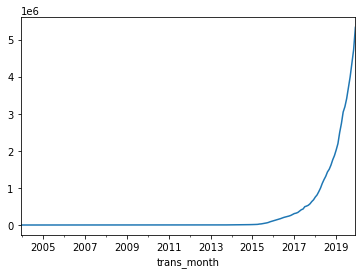

In [19]:

beta_HL['beta_HL'] = beta_HL['beta_HL']+1
beta_HL['beta_HL_cum'] = beta_HL['beta_HL'].cumprod(axis = 0)
beta_HL.set_index('trans_month',inplace = True)
beta_HL['beta_HL_cum'].plot(kind = 'line')